In [14]:
# Importation des bibliothèques nécessaires
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import googlenet
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from torchvision.datasets import ImageFolder

In [2]:
from google.colab import files
import zipfile

# Téléchargez le fichier zip depuis votre ordinateur local
uploaded = files.upload()

# Spécifiez le nom du fichier zip
Database_zip = list(uploaded.keys())[0]

# Extrayez le contenu du fichier zip dans le répertoire de destination
with zipfile.ZipFile(Database_zip, 'r') as zip_ref:
    zip_ref.extractall("Database")

Saving archive.zip to archive.zip


In [3]:
train_dataset_path = '/content/Database/train/'
valid_dataset_path = '/content/Database/test/'

In [4]:
# Définition des paramètres
EPOCHS = 20
LR = 0.001
BATCH_SIZE = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [21]:
import torch.nn as nn
import torchvision.models as models

class CustomGoogleNet(nn.Module):
    def __init__(self, num_classes=7):
        super(CustomGoogleNet, self).__init__()
        # Chargez le modèle GoogleNet pré-entraîné sur ImageNet
        self.googlenet = models.googlenet(pretrained=True)

        # Modifiez la couche de classification pour correspondre au nombre de classes spécifié
        self.googlenet.fc = nn.Linear(self.googlenet.fc.in_features, num_classes)

    def forward(self, x):
        return self.googlenet(x)

In [9]:
# Création du modèle personnalisé
googlenet_model = CustomGoogleNet(num_classes=7)
googlenet_model.to(DEVICE)
googlenet_optimizer = optim.Adam(googlenet_model.parameters(), lr=LR)

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 144MB/s]


In [10]:
# Définition des transformations pour le chargement des données
train_augs = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20, +20)),
    transforms.ToTensor()
])

In [11]:
valid_augs = transforms.Compose([transforms.ToTensor()])

In [15]:
# Load Datasets
trainset = ImageFolder(train_dataset_path, transform=train_augs)
validset = ImageFolder(valid_dataset_path, transform=valid_augs)

In [16]:
# Création des chargeurs de données
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [17]:
# Fonction pour calculer la précision multiclasse
def multiclass_accuracy(y_pred, y_true):
    top_p, top_class = y_pred.topk(1, dim=1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))

In [22]:
# Fonctions d'entraînement et d'évaluation
def train_fn(model, dataloader, optimizer, current_epoch):
    model.train()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc="EPOCHS" + "[TRAIN]" + str(current_epoch + 1) + "/" + str(EPOCHS))
    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        loss = nn.CrossEntropyLoss()(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss': '%6f' % float(total_loss / (t + 1)), 'acc': '%6f' % float(total_acc / (t + 1))})
    return total_loss / len(dataloader), total_acc / len(dataloader)


In [23]:
def eval_fn(model, dataloader, current_epoch):
    model.eval()
    total_loss = 0.0
    total_acc = 0.0
    tk = tqdm(dataloader, desc="EPOCH" + "[VALID]" + str(current_epoch + 1) + "/" + str(EPOCHS))
    for t, data in enumerate(tk):
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        logits = model(images)
        loss = nn.CrossEntropyLoss()(logits, labels)

        total_loss += loss.item()
        total_acc += multiclass_accuracy(logits, labels)
        tk.set_postfix({'loss': '%6f' % float(total_loss / (t + 1)), 'acc': '%6f' % float(total_acc / (t + 1))})
    return total_loss / len(dataloader), total_acc / len(dataloader)

In [25]:
# Listes pour stocker les valeurs d'accuracy et loss pour l'affichage graphique
googlenet_train_accuracies = []
googlenet_train_losses = []
googlenet_valid_accuracies = []
googlenet_valid_losses = []

# Boucle d'entraînement
for epoch in range(EPOCHS):
    googlenet_train_loss, googlenet_train_acc = train_fn(googlenet_model, trainloader, googlenet_optimizer, epoch)
    googlenet_eval_loss, googlenet_eval_acc = eval_fn(googlenet_model, validloader, epoch)

    # Ajout des valeurs pour l'affichage graphique
    googlenet_train_accuracies.append(googlenet_train_acc)
    googlenet_train_losses.append(googlenet_train_loss)
    googlenet_valid_accuracies.append(googlenet_eval_acc)
    googlenet_valid_losses.append(googlenet_eval_loss)

    # Print progress
    print(f'Epoch [{epoch + 1}/{EPOCHS}], '
          f'GoogleNet Train Loss: {googlenet_train_loss:.4f}, Train Acc: {googlenet_train_acc:.4f}, '
          f'GoogleNet Valid Loss: {googlenet_eval_loss:.4f}, Valid Acc: {googlenet_eval_acc:.4f}')

    # Vérification de l'amélioration des pertes de validation
    if googlenet_eval_loss < best_valid_losses['googlenet']:
        torch.save(googlenet_model.state_dict(), 'best-googlenet-weights.pt')
        print("Saved Best GoogleNet Valid Loss")
        best_valid_losses['googlenet'] = googlenet_eval_loss

# Affichage du résultat final
print(best_valid_losses['googlenet'])

EPOCH[VALID]1/20: 100%|██████████| 225/225 [00:05<00:00, 40.10it/s, loss=1.362915, acc=0.473528]


Epoch [1/20], GoogleNet Train Loss: 1.2767, Train Acc: 0.5176, GoogleNet Valid Loss: 1.3629, Valid Acc: 0.4735
Saved Best GoogleNet Valid Loss


EPOCH[VALID]2/20: 100%|██████████| 225/225 [00:05<00:00, 39.48it/s, loss=1.502653, acc=0.482639]


Epoch [2/20], GoogleNet Train Loss: 1.2272, Train Acc: 0.5412, GoogleNet Valid Loss: 1.5027, Valid Acc: 0.4826


EPOCH[VALID]3/20: 100%|██████████| 225/225 [00:05<00:00, 39.36it/s, loss=1.125618, acc=0.578611]


Epoch [3/20], GoogleNet Train Loss: 1.1749, Train Acc: 0.5614, GoogleNet Valid Loss: 1.1256, Valid Acc: 0.5786
Saved Best GoogleNet Valid Loss


EPOCH[VALID]4/20: 100%|██████████| 225/225 [00:06<00:00, 37.22it/s, loss=1.067872, acc=0.604167]


Epoch [4/20], GoogleNet Train Loss: 1.1174, Train Acc: 0.5834, GoogleNet Valid Loss: 1.0679, Valid Acc: 0.6042
Saved Best GoogleNet Valid Loss


EPOCH[VALID]5/20: 100%|██████████| 225/225 [00:06<00:00, 35.07it/s, loss=1.103159, acc=0.588056]


Epoch [5/20], GoogleNet Train Loss: 1.0898, Train Acc: 0.5908, GoogleNet Valid Loss: 1.1032, Valid Acc: 0.5881


EPOCH[VALID]6/20: 100%|██████████| 225/225 [00:06<00:00, 35.98it/s, loss=1.075087, acc=0.606250]


Epoch [6/20], GoogleNet Train Loss: 1.0699, Train Acc: 0.5996, GoogleNet Valid Loss: 1.0751, Valid Acc: 0.6062


EPOCH[VALID]7/20: 100%|██████████| 225/225 [00:06<00:00, 36.23it/s, loss=1.066564, acc=0.609722]


Epoch [7/20], GoogleNet Train Loss: 1.0425, Train Acc: 0.6107, GoogleNet Valid Loss: 1.0666, Valid Acc: 0.6097
Saved Best GoogleNet Valid Loss


EPOCH[VALID]8/20: 100%|██████████| 225/225 [00:05<00:00, 39.13it/s, loss=1.034548, acc=0.620556]


Epoch [8/20], GoogleNet Train Loss: 1.0221, Train Acc: 0.6186, GoogleNet Valid Loss: 1.0345, Valid Acc: 0.6206
Saved Best GoogleNet Valid Loss


EPOCH[VALID]9/20: 100%|██████████| 225/225 [00:05<00:00, 39.82it/s, loss=1.163324, acc=0.593167]


Epoch [9/20], GoogleNet Train Loss: 0.9883, Train Acc: 0.6312, GoogleNet Valid Loss: 1.1633, Valid Acc: 0.5932


EPOCH[VALID]10/20: 100%|██████████| 225/225 [00:06<00:00, 37.08it/s, loss=1.045822, acc=0.623611]


Epoch [10/20], GoogleNet Train Loss: 0.9731, Train Acc: 0.6369, GoogleNet Valid Loss: 1.0458, Valid Acc: 0.6236


EPOCH[VALID]11/20: 100%|██████████| 225/225 [00:06<00:00, 35.86it/s, loss=1.013691, acc=0.627639]


Epoch [11/20], GoogleNet Train Loss: 0.9558, Train Acc: 0.6490, GoogleNet Valid Loss: 1.0137, Valid Acc: 0.6276
Saved Best GoogleNet Valid Loss


EPOCH[VALID]12/20: 100%|██████████| 225/225 [00:06<00:00, 34.84it/s, loss=0.993399, acc=0.636222]


Epoch [12/20], GoogleNet Train Loss: 0.9360, Train Acc: 0.6522, GoogleNet Valid Loss: 0.9934, Valid Acc: 0.6362
Saved Best GoogleNet Valid Loss


EPOCH[VALID]13/20: 100%|██████████| 225/225 [00:06<00:00, 36.54it/s, loss=0.973947, acc=0.641222]


Epoch [13/20], GoogleNet Train Loss: 0.9075, Train Acc: 0.6608, GoogleNet Valid Loss: 0.9739, Valid Acc: 0.6412
Saved Best GoogleNet Valid Loss


EPOCH[VALID]14/20: 100%|██████████| 225/225 [00:05<00:00, 39.18it/s, loss=0.996960, acc=0.627500]


Epoch [14/20], GoogleNet Train Loss: 0.8992, Train Acc: 0.6664, GoogleNet Valid Loss: 0.9970, Valid Acc: 0.6275


EPOCH[VALID]15/20: 100%|██████████| 225/225 [00:05<00:00, 39.51it/s, loss=0.958112, acc=0.649167]


Epoch [15/20], GoogleNet Train Loss: 0.8774, Train Acc: 0.6747, GoogleNet Valid Loss: 0.9581, Valid Acc: 0.6492
Saved Best GoogleNet Valid Loss


EPOCH[VALID]16/20: 100%|██████████| 225/225 [00:06<00:00, 36.34it/s, loss=1.012655, acc=0.642222]


Epoch [16/20], GoogleNet Train Loss: 0.8578, Train Acc: 0.6804, GoogleNet Valid Loss: 1.0127, Valid Acc: 0.6422


EPOCH[VALID]17/20: 100%|██████████| 225/225 [00:06<00:00, 34.15it/s, loss=1.072717, acc=0.604361]


Epoch [17/20], GoogleNet Train Loss: 0.8403, Train Acc: 0.6893, GoogleNet Valid Loss: 1.0727, Valid Acc: 0.6044


EPOCH[VALID]18/20: 100%|██████████| 225/225 [00:06<00:00, 34.55it/s, loss=1.052664, acc=0.613389]


Epoch [18/20], GoogleNet Train Loss: 0.8160, Train Acc: 0.7010, GoogleNet Valid Loss: 1.0527, Valid Acc: 0.6134


EPOCH[VALID]19/20: 100%|██████████| 225/225 [00:05<00:00, 37.69it/s, loss=1.038119, acc=0.629417]


Epoch [19/20], GoogleNet Train Loss: 0.7967, Train Acc: 0.7081, GoogleNet Valid Loss: 1.0381, Valid Acc: 0.6294


EPOCH[VALID]20/20: 100%|██████████| 225/225 [00:05<00:00, 39.21it/s, loss=1.013567, acc=0.636917]

Epoch [20/20], GoogleNet Train Loss: 0.7872, Train Acc: 0.7088, GoogleNet Valid Loss: 1.0136, Valid Acc: 0.6369
0.9581117534306314


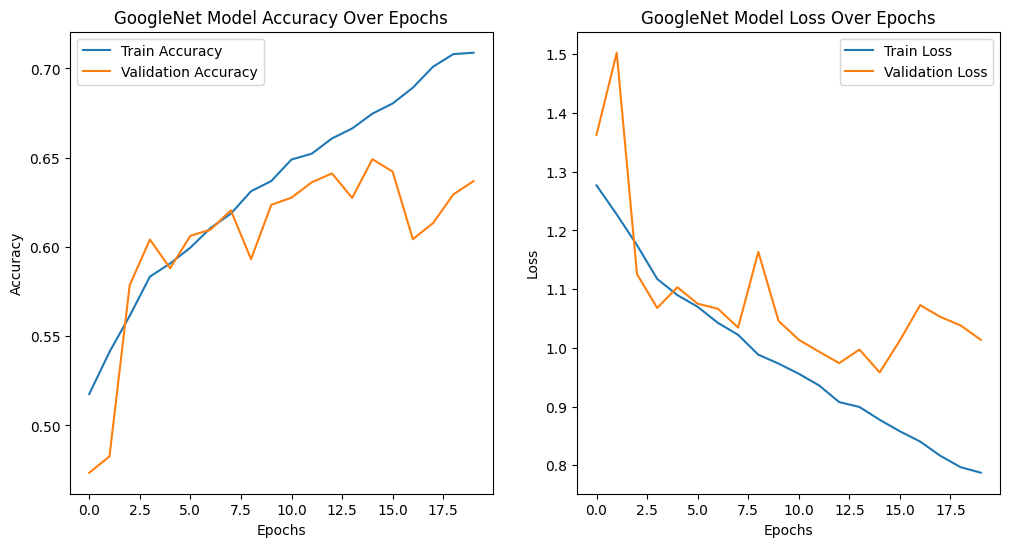

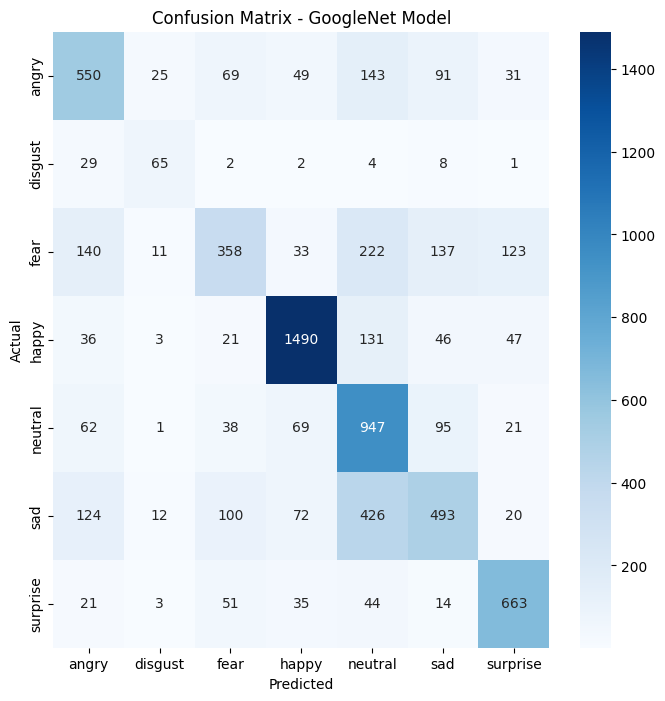

Overall Accuracy: 63.61%


In [26]:
# Affichage des graphiques
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(googlenet_train_accuracies, label='Train Accuracy')
plt.plot(googlenet_valid_accuracies, label='Validation Accuracy')
plt.title('GoogleNet Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(googlenet_train_losses, label='Train Loss')
plt.plot(googlenet_valid_losses, label='Validation Loss')
plt.title('GoogleNet Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Calcul et affichage de la matrice de confusion
googlenet_model.eval()
all_preds = []
all_labels = []

for images, labels in validloader:
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    logits = googlenet_model(images)
    preds = torch.argmax(logits, dim=1).cpu().numpy()

    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

conf_mat = confusion_matrix(all_labels, all_preds)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

plt.figure(figsize=(8, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - GoogleNet Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calcul et affichage de la précision globale
overall_accuracy = accuracy_score(all_labels, all_preds)
print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')